Hamiltonian-Simulation Benchmark Program - Cirq
... execution starting at Jun 06, 2024 09:39:32 UTC
************
Executing [1] circuits with num_qubits = 2
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.001, 0.005, 0.005 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 0.998, 0.998

************
Executing [1] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.006, 0.006 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.998, 0.998

************
Executing [1] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.008, 0.008 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 0.998, 0.998

************
Executing [1] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.002, 0.01, 0.01 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 0.995, 0.995

******

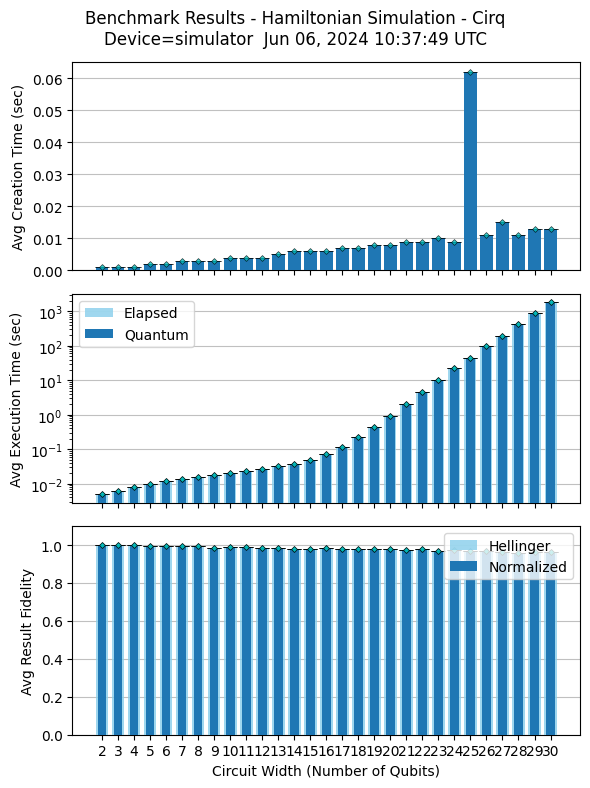

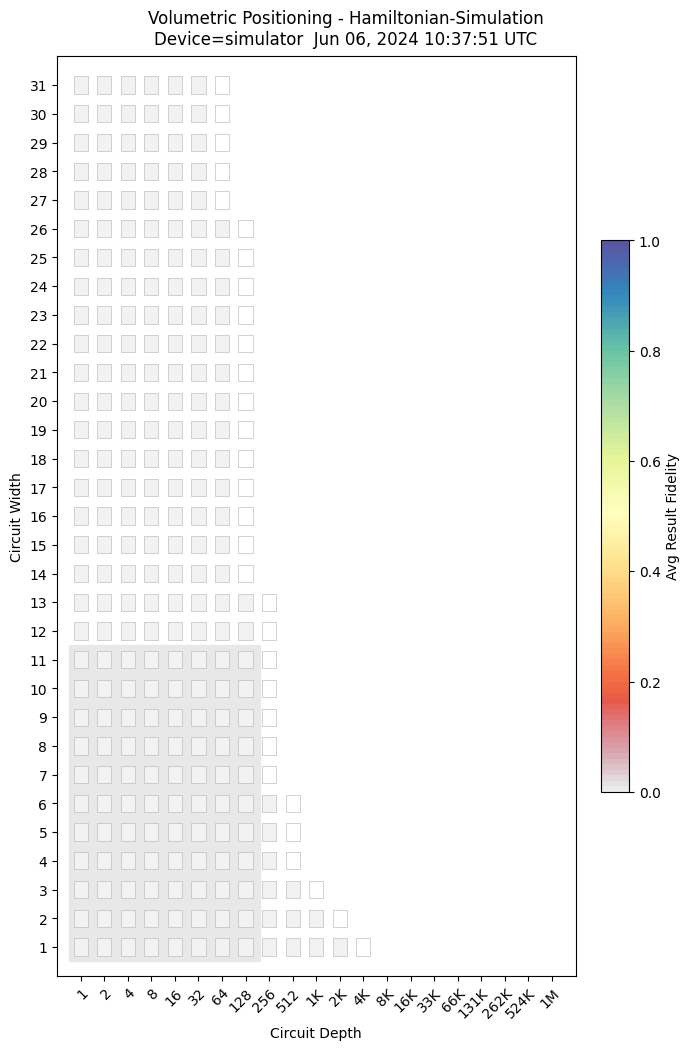

In [1]:
"""
Hamiltonian-Simulation Benchmark Program - Cirq
"""

import json
import os
import sys
import time
from collections import defaultdict

import numpy as np

import cirq

sys.path[1:1] = ["_common", "_common/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits and subcircuits for display
QC_ = None
XX_ = None
YY_ = None
ZZ_ = None
XXYYZZ_ = None

# for validating the implementation of XXYYZZ operation
_use_XX_YY_ZZ_gates = False

# import precalculated data to compare against
filename = os.path.join(os.path.pardir, "_common", "precalculated_data.json")
with open(filename, 'r') as file:
    data = file.read()
precalculated_data = json.loads(data)

############### Circuit Definition

def HamiltonianSimulation(n_spins, K, t, w, h_x, h_z):
    '''
    Construct a Cirq circuit for Hamiltonian Simulation
    :param n_spins:The number of spins to simulate
    :param K: The Trotterization order
    :param t: duration of simulation
    :return: return a cirq circuit for this Hamiltonian
    '''
    
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(n_spins)]
    qc = cirq.Circuit()
    tau = t / K

    # start with initial state of 1010101...
    for k in range(0, n_spins, 2):
        qc.append(cirq.X(qr[k]))

    # loop over each trotter step, adding gates to the circuit defining the hamiltonian
    for k in range(K):
    
        # the Pauli spin vector product
        qc.append([cirq.rx(2 * tau * w * h_x[i])(qr[i]) for i in range(n_spins)])
        qc.append([cirq.rz(2 * tau * w * h_z[i])(qr[i]) for i in range(n_spins)])

        # Basic implementation of exp(i * t * (XX + YY + ZZ))
        if _use_XX_YY_ZZ_gates:
        
            # XX operator on each pair of qubits in a loop
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(xx_gate(tau).on(qr[i], qr[(i+1) % n_spins]))
        
            # YY operator on each pair of qubits in a loop
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(yy_gate(tau).on(qr[i], qr[(i+1) % n_spins]))

            # ZZ operation on each pair of qubits in a loop
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(zz_gate(tau).on(qr[i], qr[(i+1) % n_spins]))

        # Use an optimal XXYYZZ combined operator
        # See equation 1 and Figure 6 in https://arxiv.org/pdf/quant-ph/0308006.pdf
        else:

            # optimized XX + YY + ZZ operator on each pair of qubits in a loop
            for j in range(2):
                for i in range(j % 2, n_spins - 1, 2):
                    qc.append(xxyyzz_opt_gate(tau).on(qr[i], qr[(i+1) % n_spins]))

    # measure all the qubits used in the circuit
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(n_spins)], key='result'))

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or n_spins <= 6:
        if n_spins < 9: QC_ = qc

    return qc

############### XX, YY, ZZ Gate Implementations

# Simple XX gate on qidx1 and qidx2 with angle 'tau'
def xx_gate(tau):
    qr = [cirq.GridQubit(i, 0) for i in range(2)]
    qc = cirq.Circuit()
    qc.append([
            cirq.H(qr[0]),
            cirq.H(qr[1]),
            cirq.CNOT(qr[0], qr[1]),
            cirq.rz(2 * tau)(qr[1]),
            cirq.CNOT(qr[0], qr[1]),
            cirq.H(qr[0]),
            cirq.H(qr[1])
            ])

    global XX_
    XX_ = qc

    return cirq_utils.to_gate(num_qubits=2, circ=qc, name="XX")    
            
# Simple YY gate on qidx1 and qidx2 with angle 'tau'
def yy_gate(tau):
    qr = [cirq.GridQubit(i, 0) for i in range(2)]
    qc = cirq.Circuit()
    qc.append([
            cirq.S(qr[0]), cirq.S(qr[1]),
            cirq.H(qr[0]), cirq.H(qr[1]),
            cirq.CNOT(qr[0], qr[1]),
            cirq.rz(2 * tau)(qr[1]),
            cirq.CNOT(qr[0], qr[1]),
            cirq.H(qr[0]), cirq.H(qr[1]),
            cirq.ZPowGate(exponent=-0.5)(qr[0]),   # the s dagger gate, not built-in to cirq
            cirq.ZPowGate(exponent=-0.5)(qr[1])
            ])
    
    global YY_
    YY_ = qc

    return cirq_utils.to_gate(num_qubits=2, circ=qc, name="YY")    

# Simple YY gate on qidx1 and qidx2 with angle 'tau'
def zz_gate(tau):
    qr = [cirq.GridQubit(i, 0) for i in range(2)]
    qc = cirq.Circuit()
    qc.append([
            cirq.CNOT(qr[0], qr[1]),
            cirq.rz(2 * tau)(qr[1]),
            cirq.CNOT(qr[0], qr[1]),
            ])

    global ZZ_
    ZZ_ = qc

    return cirq_utils.to_gate(num_qubits=2, circ=qc, name="ZZ")    

# Optimal XXYYZZ gate on qidx1 and qidx2 with angle 'tau'
def xxyyzz_opt_gate(tau):
    qr = [cirq.GridQubit(i, 0) for i in range(2)]
    qc = cirq.Circuit()
    qc.append([
           cirq.rz(-np.pi / 2)(qr[1]),
           cirq.CNOT(qr[1], qr[0]),
           cirq.rz(-tau + np.pi / 2)(qr[0]),
           cirq.ry(-np.pi / 2 + tau)(qr[1]),
           cirq.CNOT(qr[0], qr[1]),
           cirq.ry(-tau + np.pi / 2)(qr[1]),
           cirq.CNOT(qr[1], qr[0]),
           cirq.rz(np.pi / 2)(qr[0])
           ])

    global XXYYZZ_
    XXYYZZ_ = qc

    return cirq_utils.to_gate(num_qubits=2, circ=qc, name="XXYYZZ")            

############### Result Data Analysis

# Analyze and print measured results
# Compute the quality of the result based on operator expectation for each state
def analyze_and_print_result(qc, result, num_qubits, type, num_shots):

    # get measurement array
    measurements = result.measurements['result']
    
    # create counts distribution
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
    if verbose: print(f"For type {type} measured: {counts}")

    # we have precalculated the correct distribution that a perfect quantum computer will return
    # it is stored in the json file we import at the top of the code
    correct_dist = precalculated_data[f"Qubits - {num_qubits}"]
    if verbose: print(f"Correct dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity


################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=2, max_qubits=30, max_circuits=3, num_shots=1000,
    use_XX_YY_ZZ_gates = False,
        backend_id='simulator', provider_backend=None):

    print("Hamiltonian-Simulation Benchmark Program - Cirq")
    
    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # set the flag to use an XX YY ZZ shim if given
    global _use_XX_YY_ZZ_gates
    _use_XX_YY_ZZ_gates = use_XX_YY_ZZ_gates
    if _use_XX_YY_ZZ_gates:
        print("... using unoptimized XX YY ZZ gates")

    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, type, num_shots):
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, expectation_a = analyze_and_print_result(qc, result, num_qubits, type, num_shots)
        metrics.store_metric(num_qubits, type, 'fidelity', expectation_a)

    # Initialize execution module   with the result handler  
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):

        # determine number of circuits to execute for this group
        num_circuits = min(1, max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # parameters of simulation
        #### CANNOT BE MODIFIED W/O ALSO MODIFYING PRECALCULATED DATA #########
        w = precalculated_data['w']  # strength of disorder
        k = precalculated_data['k']  # Trotter error.
               # A large Trotter order approximates the Hamiltonian evolution better.
               # But a large Trotter order also means the circuit is deeper.
               # For ideal or noise-less quantum circuits, k >> 1 gives perfect hamiltonian simulation.
        t = precalculated_data['t']  # time of simulation
        #######################################################################

        # loop over only 1 circuit
        for circuit_id in range(num_circuits):
        
            # create the circuit for given qubit size and simulation parameters, store time metric
            ts = time.time()
            h_x = precalculated_data['h_x'][:num_qubits] # precalculated random numbers between [-1, 1]
            h_z = precalculated_data['h_z'][:num_qubits]
            qc = HamiltonianSimulation(num_qubits, K=k, t=t, w=w, h_x= h_x, h_z=h_z)
            metrics.store_metric(num_qubits, circuit_id, 'create_time', time.time() - ts)
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, circuit_id, num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(num_qubits)
    # metrics.report_metrics_for_group(num_qubits)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")

    if _use_XX_YY_ZZ_gates:
        print("\nXX, YY, ZZ =")
        print(XX_); print(YY_); print(ZZ_)
    else:
        print("\nXXYYZZ_opt =")
        print(XXYYZZ_)

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Hamiltonian Simulation - Cirq")


# if main, execute method
if __name__ == '__main__': run()
